#Obtaining Spectra from Direct Imaging Observations


---

*Emily Rickman*



This tutorial will be split into two parts:

*   How to obtain flux values from images
*   How to fit an atmospheric model to a directly imaged companion

But first of all we must understand what the observing sequence of a direct imaging observation looks like.



# Angular Differential Imaging (ADI)

---

Images are taken over a long observing sequence as the pupil de-rotates on the sky. The difference between the telescope pupil orientation and the sky object or 'field' orientation is known as the parallactic angle, and is critical to de-roate and stack images to obtain as high a S/N as posssible. 

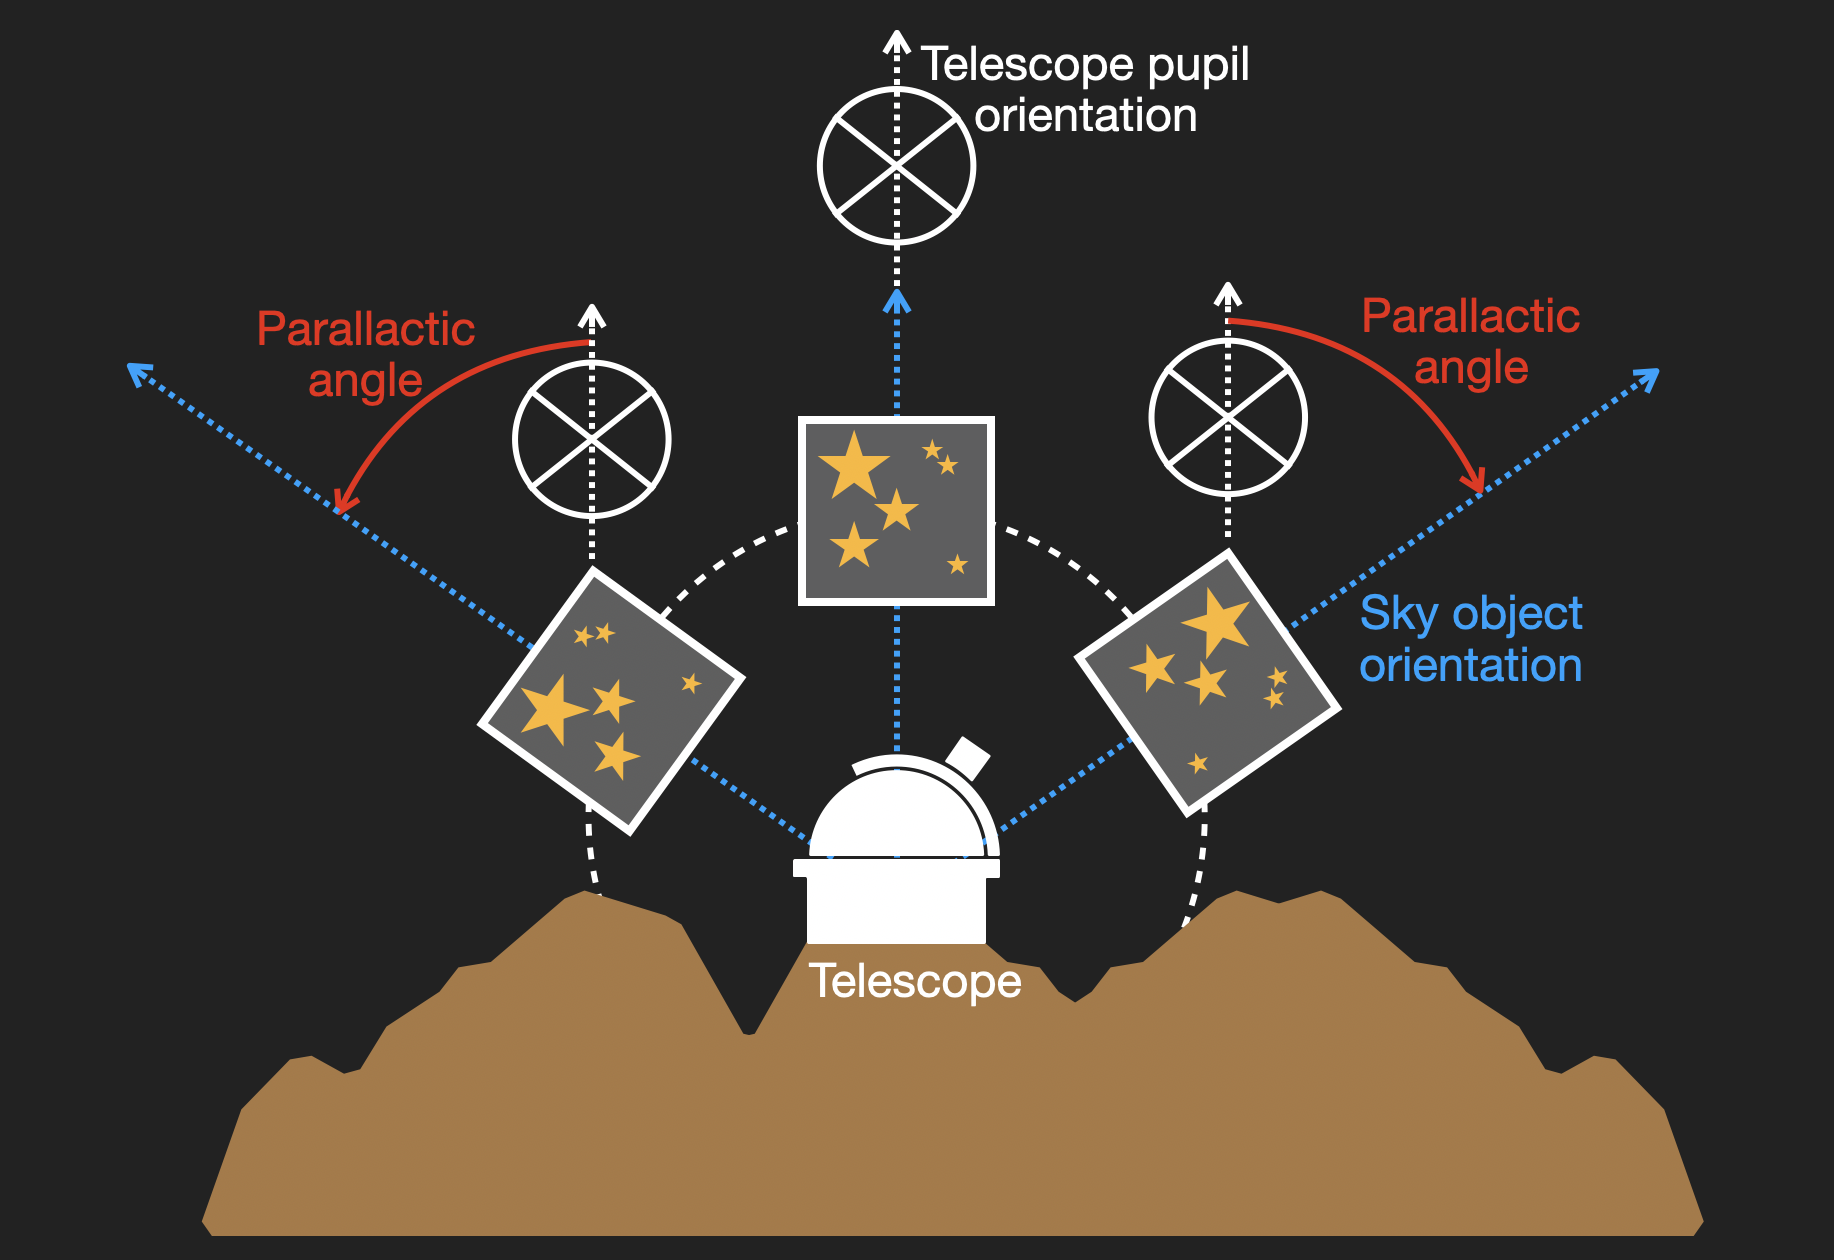

Some of the ESO instruments that are capable of direct imaging observations of exoplanets and brown dwarfs include SPHERE and GRAVITY, as well as the now decommissioned NACO.

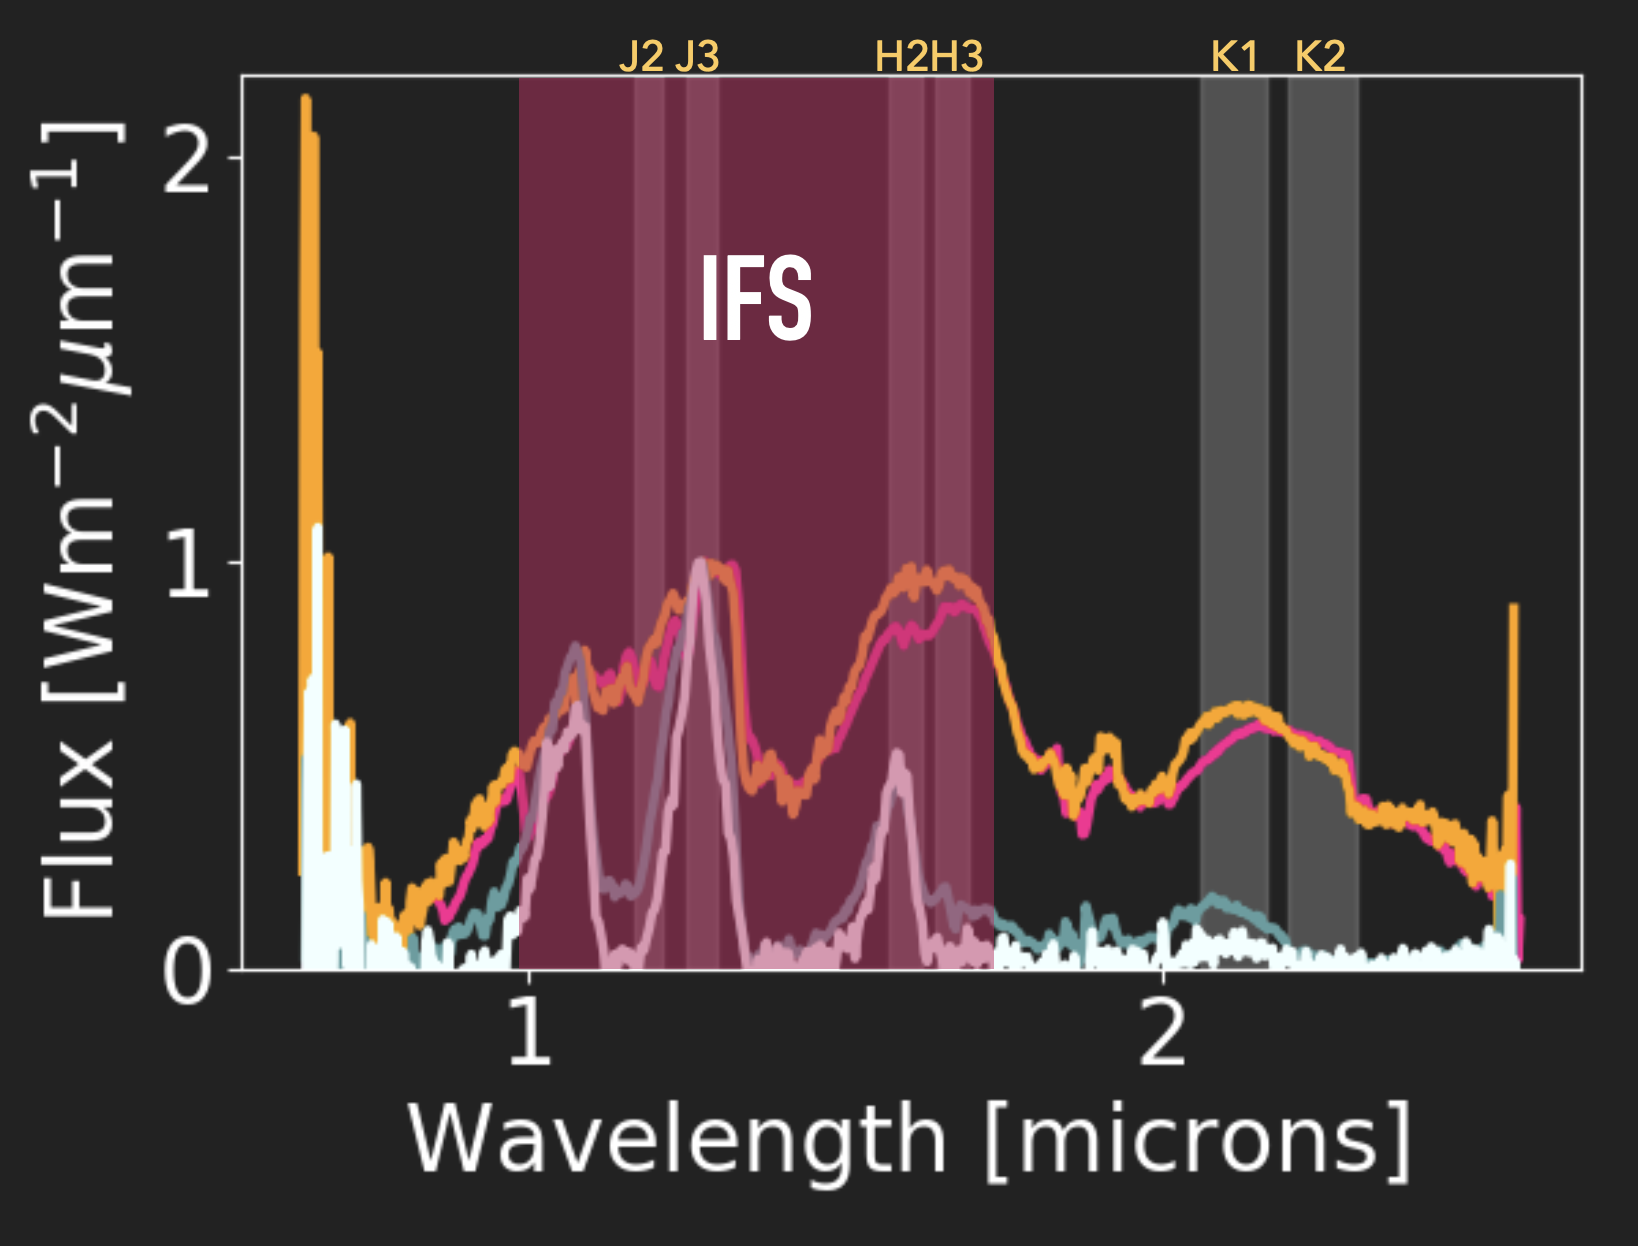

Install the necessary packages onto Google Colab:

In [ ]:
!pip install vip_hci
#!pip install pyds9
!pip install species

Import necessary python packages:

Here we are making using of Vortex Image Processing Package (VIP) (Gomez Gonzalez et al. 2017), where the full documentation can be found here: https://vip.readthedocs.io/en/latest/


In [ ]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

Import data using git clone:

In [ ]:
from google.colab import drive
#drive.mount('/content/drive', force_remount=True) # uncomment if loading data from Google Drive (private only)
!rm -r eso_atmo_2021/
!git clone https://github.com/emrickman/eso_atmo_2021

Cloning into 'eso_atmo_2021'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


Load cube of NACO ADI data:

In [ ]:
#vip.fits.info_fits('/content/drive/My Drive/ESO_atmo_workshop/naco_betapic_cube.fits') # uncomment if loading data from Google Drive (private only)
vip.fits.info_fits('/content/eso_atmo_2021/naco_betapic_cube.fits')

Filename: /content/eso_atmo_2021/naco_betapic_cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (101, 101, 61)   float32   


Also load NACO point spread function (PSF), and parallactic angle (PA) list:

In [ ]:
#cube = '/content/drive/My Drive/ESO_atmo_workshop/naco_betapic_cube.fits'            # uncomment if loading data from Google Drive (private only)
#psfnaco = '/content/drive/My Drive/ESO_atmo_workshop/naco_betapic_psf.fits'          # uncomment if loading data from Google Drive (private only)
#angs = '/content/drive/My Drive/ESO_atmo_workshop/naco_betapic_pa.fits'              # uncomment if loading data from Google Drive (private only)

cube = '/content/eso_atmo_2021/naco_betapic_cube.fits'
psfnaco = '/content/eso_atmo_2021/naco_betapic_psf.fits'
angs = '/content/eso_atmo_2021/naco_betapic_pa.fits'

cube_orig = vip.fits.open_fits(cube)
psf = vip.fits.open_fits(psfnaco)
angs = vip.fits.open_fits(angs)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61, 1)


To measure the Full Width Half Maximum (FWHM) by fitting a 2D Gaussian to the core of the PSF:

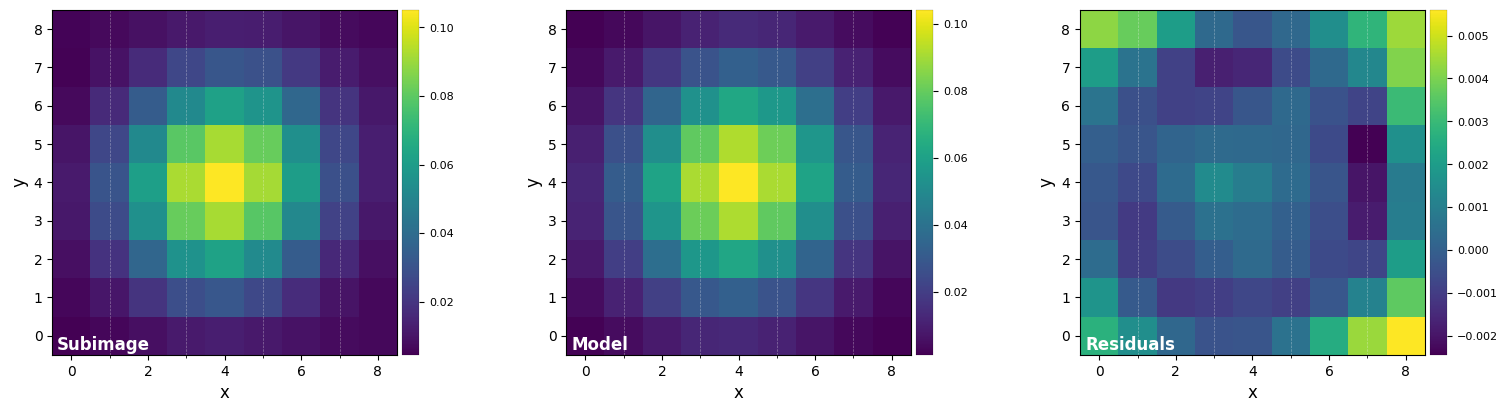

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [ ]:
_ = vip.var.fit_2dgaussian(psf, crop=True, cropsize=9, debug=True)

In [ ]:
fwhm_naco = np.mean([4.73, 4.47])
print(fwhm_naco)

4.6


Normalise the flux to 1 in a 1xFWHM aperture and crop the PSF array:

In [ ]:
psfn = vip.metrics.normalize_psf(psf, fwhm_naco, size=19)

Flux in 1xFWHM aperture: 1.227


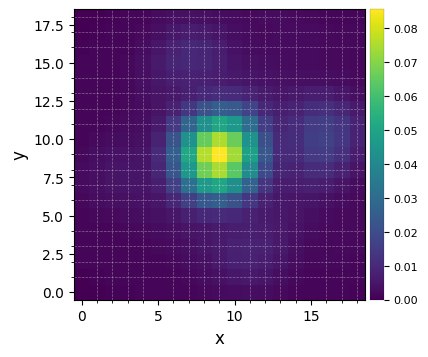

In [ ]:
plot_frames(psfn, grid=True, size_factor=4)

Define the pixel-scale for NACO:

In [ ]:
pxscale_naco = vip.conf.VLT_NACO['plsc']
print(pxscale_naco) # arcsec/pixel

0.02719


It is necessary to re-centre all of the frames in the ADI sequence to obtain as high as S/N as possible.

New shape: (15, 15)


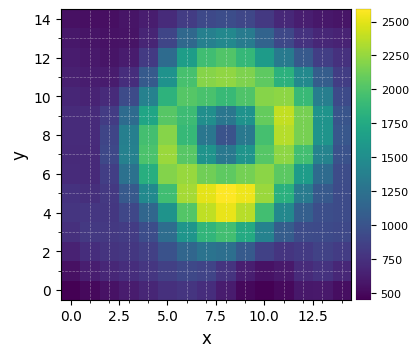

In [ ]:
plot_frames(vip.preproc.frame_crop(cube_orig[0], 15), grid=True, size_factor=4)

We can use a 2D Gaussian fit to shift the frames to the same central position.

In [ ]:
from vip_hci.preproc import cube_recenter_2dfit

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-08-23 12:42:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d Gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.856779
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


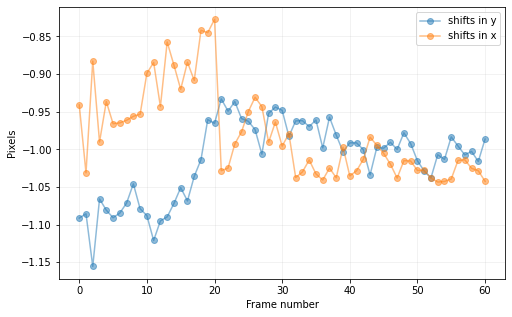

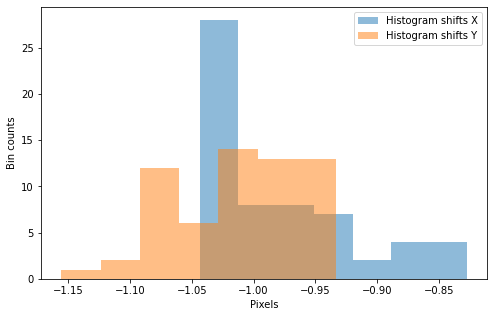

In [ ]:
cube1, shy1, shx1 = cube_recenter_2dfit(cube_orig, xy=(51, 51), fwhm=fwhm_naco, nproc=1, subi_size=5, 
                                        model='gauss', negative=True, full_output=True, debug=False)

In [ ]:
cube = cube1

And let's check the first frame of the sequence after the shift was applied:

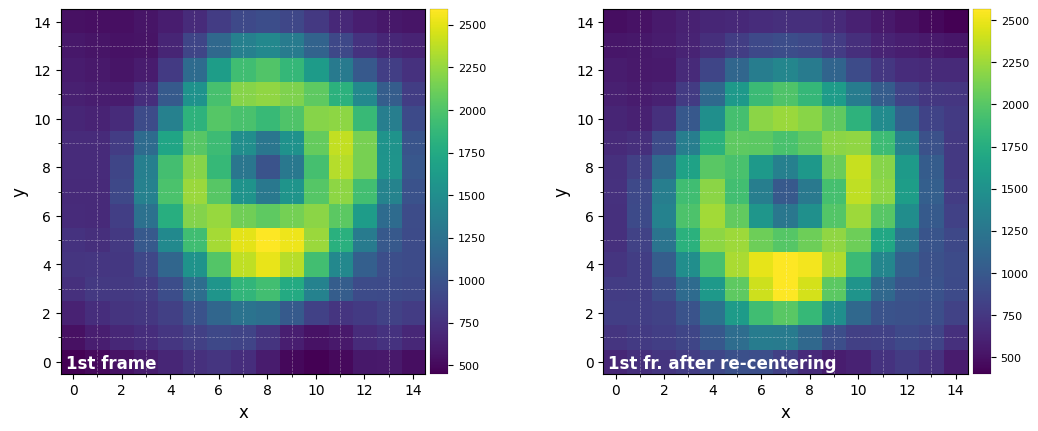

In [ ]:
im1 = vip.preproc.frame_crop(cube_orig[0], 15, verbose=False)
im2 = vip.preproc.frame_crop(cube[0], 15, verbose=False)
plot_frames((im1, im2), grid=True, label=('1st frame', '1st fr. after re-centering'))

One way to fit for the position and flux of the detected companion is to inject a fake negative PSF with an arbitrary flux using the normalised PSF. 

Let's load the function necessary to inject fake companions into the image:

In [ ]:
from vip_hci.metrics import cube_inject_companions

In [ ]:
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=400, plsc=pxscale_naco, 
                                rad_dists=[30.5], theta=240, n_branches=1)

Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs from center)


Let's optimise the S/N with full-frame ADI Principal Component Analysis (PCA) at the position of the injected companion:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-08-23 12:44:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 13.622 GB
System available memory = 12.570 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.065118
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Number of steps 31
Optimal number of PCs = 15, for S/N=11.481
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 35.0, 23.0
Flux in a centered 1xFWHM circular aperture = 83.247
Central pixel S/N = 13.276
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 11.481
Max S/N (shifting the aperture center) = 17.507
stddev S/N (shifting the aperture center) = 4.522



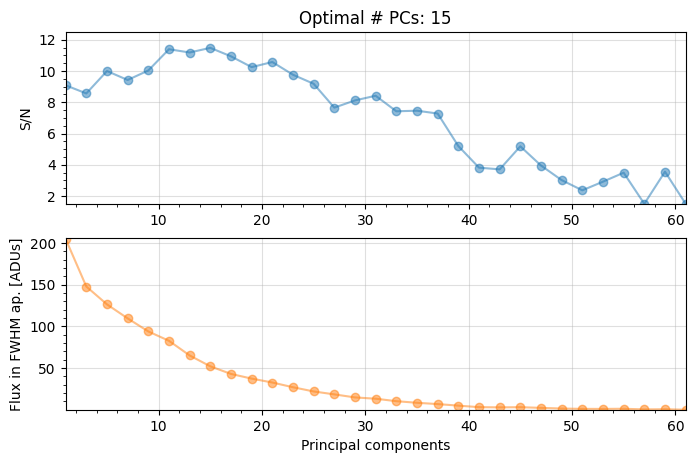

In [ ]:
fr_pca3 = vip.pca.pca(cubefc, angs, fwhm=fwhm_naco, source_xy=(35,23), 
                       mask_center_px=None, ncomp=(1, 61, 2))

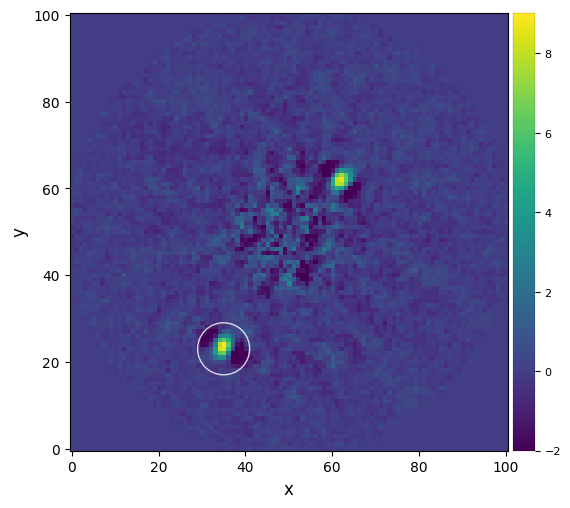

In [ ]:
plot_frames(fr_pca3, vmin=-2, colorbar=True, circle=(35, 23))

In [ ]:
_ = vip.metrics.snr(fr_pca3, fwhm=fwhm_naco, source_xy=(35,23), verbose=True)

S/N for the given pixel = 13.276
Integrated flux in FWHM test aperture = 83.247
Mean of background apertures integrated fluxes = -2.503
Std-dev of background apertures integrated fluxes = 6.382


In [ ]:
from vip_hci.negfc import firstguess

The Negative Fake Companion technique (NEGFC) works using the following steps:

*   Estimate the biased position and flux of the planet from the first reduced image
*   Use the measured off-axis PSF as a template to remove the first estimate from the cleaned data cube
*   Process the cube with PCA
*   Iterate on the position and the flux until a well-chosen function of merit minimised.

---

We obtain a first estimation of the flux and position by running a grid minimisation and a Nelder-Mead minimisation. Initially the minimisation of $\chi^2$ by trying a grid of values for the flux. If the parameter 'simplex' is set to *True* then a Nelder-Mead (simplex) minimisation is done based on the preliminary guess of the initial grid minimisation. 


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-08-23 12:45:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [35,23], running ...
Step | flux    | chi2r
1/100   0.000   0.130
2/100   50.505   0.127
3/100   101.010   0.125
4/100   151.515   0.121
5/100   202.020   0.115
6/100   252.525   0.111
7/100   303.030   0.110
8/100   353.535   0.107
9/100   404.040   0.108
10/100   454.545   0.111
11/100   505.051   0.115


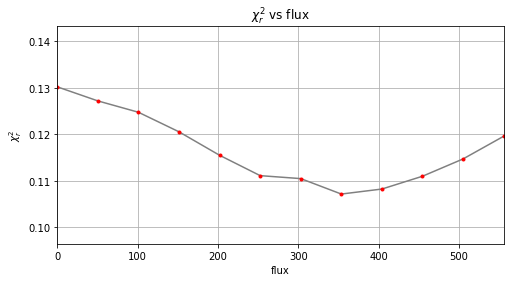

Planet 0: preliminary guess: (r, theta, f)=(30.9, 240.9, 353.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 66, nfev: 169, chi2r: 0.0892681388697997
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.375, 240.064, 356.556) at 
          (X,Y)=(34.84, 23.68)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:25.845039
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [ ]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=30, plsc=pxscale_naco,
                               planets_xy_coord=[(35, 23)], fwhm=fwhm_naco, 
                               f_range=None, annulus_width=3, aperture_radius=3,
                               simplex=True, plot=True, verbose=True)

Let's use the values obtained with the simplex optimization to subtract the planet with the following function:

In [ ]:
from vip_hci.negfc import cube_planet_free


First we define a list with the parameters (r, theta, flux) obtained via the NEGFC technique:

In [ ]:
plpar_bpicb = [(r_0, theta_0, f_0)]


In [ ]:
cube_emp = cube_planet_free(plpar_bpicb, cubefc, angs, psfn, pxscale_naco)

In [ ]:
fr_pca_emp = vip.pca.pca(cube_emp, angs, ncomp=19, verbose=False)

Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame as a result of processing the planet-subtracted cube:

In [ ]:
cropped_frame1 = vip.preproc.frame_crop(fr_pca3, cenxy=(35, 23), size=15)

New shape: (15, 15)


In [ ]:
cropped_frame2 = vip.preproc.frame_crop(fr_pca_emp, cenxy=(35, 23), size=15)

New shape: (15, 15)


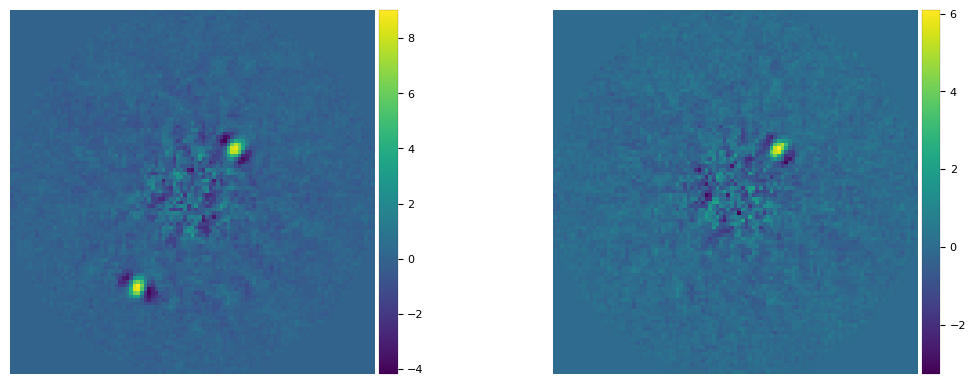

In [ ]:
plot_frames((fr_pca3, fr_pca_emp), axis=False)

To carry out a more robust way of obtaining the flux and position, the NEGFC technique can be coupled with MCMC to sample the posterior distributuion of the parameters, as well as generating error bars. A full explanation of this can be found at https://vip.readthedocs.io/en/latest/ 

---

Between obtaining the flux at each wavelength channel (+errors), the next step is to correct for the stellar spectrum of the star itself, as well as the neutral density filters (if any) used during the observations. This is done by convolving the contrast values with the spectral energy distribution of the host star, as well as the expected transmission from the neutral density filters.

---

For this next part of the exercise, we assume that these corrections have already been applied.

# Analysing the spectrum using 'species'

The full documentation for 'species' (Stolker et al. 2020) can be found here: https://species.readthedocs.io/en/latest/overview.html

Species is a toolkit that implements publicly available photometric and spectral libraries, atmospheric model spectra, evolutionary tracks, and photometry of directly imaged, low-mass objects.

In this tutorial we are fitting for the spectrum of the ultracool benchmark brown dwarf HD13724B (Rickman et al. 2020), but species contains many examples to go over and familarise yourself with spectral and photometric analysis of directly imaged planets and brown dwarfs.


---



Firstly, we need to import the relevant python packages:

(In this case we can ignore any error with regards to pymultinest, but the full explanation of the installation of this dependency can be found in the documentation if you wish to use it for future uses).

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patheffects as PathEffects
from scipy.optimize import minimize
from scipy.special import j1
import spectres

import species
import ultranest


ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


/usr/local/lib/python3.7/dist-packages/species/analysis/fit_model.py:26: UserWarning: PyMultiNest could not be imported.
  warnings.warn('PyMultiNest could not be imported.')


Import spectrum for HD13724B (Rickman et al. 2020) and reconfigure as a .fits file necessary for species to read:

In [ ]:
sphere = []
#with open('/content/drive/My Drive/ESO_atmo_workshop/HD13724B.rdb', 'r') as f:       # uncomment if loading data from Google Drive (private only)
with open('/content/eso_atmo_2021/HD13724B.rdb', 'r') as f:
    l = f.readlines()
    for i, line in enumerate(l):
        if (i >= 9):
            temp = line.split(' ')
            sphere += [np.array([float(temp[0]), float(temp[5]), float(temp[9])])]
f.close()
sphere = np.array(sphere)

hdu = pyfits.PrimaryHDU(sphere)
hdul = pyfits.HDUList([hdu])
hdul.writeto('sphere.fits', overwrite=True, output_verify='fix')
hdul.close()

Here we are specifying the model to load into our database:

There are many different atmospheric models to choose from depending on the object that you are analysing and how much information you know prior to fitting the spectrum (i.e. if you have a mass estimate of the companion). For this example, we will load the 'atmo' model (Phillips et al. 2020).

In [ ]:
model = 'atmo'
#model = 'drift-phoenix'
#model = 'bt-settl'
#model = 'petitcode-cool-clear'
#model = 'petitcode-cool-cloudy'
#model = 'petitcode-hot-clear'
#model = 'petitcode-hot-cloudy'

Read in the distance and photometry of the object at specific wavelengths:

The parallax is taken from GAIA DR2, the fluxes are obtained using the method described in the previous portion of the tutorial. 

In [ ]:
plx = (23.0, 0.03) # mas
dist = (1./(1e-3*plx[0]), 1./(1e-3*plx[0])**2*(1e-3*plx[1])) # pc
flux = {'Paranal/SPHERE.IRDIS_D_J23_2': (1.7196342772e-16, 1.1952648729e-17), # W/m^2/um
        'Paranal/SPHERE.IRDIS_D_J23_3': (4.2081631477e-16, 3.0843373741e-18), # W/m^2/um
        'Paranal/SPHERE.IRDIS_D_H23_2': (1.946814255e-16, 2.9355372289e-18), # W/m^2/um
        'Paranal/SPHERE.IRDIS_D_H23_3': (8.7097429137e-17, 2.4622920463e-18), # W/m^2/um
        'Paranal/SPHERE.IRDIS_D_K12_1': (1.0064120589e-16, 1.7542962495e-18), # W/m^2/um
        'Paranal/SPHERE.IRDIS_D_K12_2': (3.7369535057e-17, 1.5339010257e-18)} # W/m^2/um

Intitalise the species database and add in the 'atmo' model in your workflow. This can be implemented across a number of different models e.g. petitcode, bt-settl etc, for whichever relevant models that you require.

In [ ]:
species.SpeciesInit()
database = species.Database()

if (model == 'atmo'):
    database.add_model(model='atmo',
                       wavel_range=(0.8, 2.8),
                       spec_res=1000.,
                       teff_range=(600., 1600.))

Initiating species v0.4.0... [DONE]
Database: /content/species_database.hdf5
Data folder: /content/data
Working folder: /content
Unpacking ATMO model spectra (430 MB)... [DONE]
Adding ATMO model spectra... [DONE]                          
Grid points stored in the database:
   - Teff = [ 600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500. 1600.]
   - log(g) = [2.5 3.  3.5 4.  4.5 5.  5.5]
Number of grid points per parameter:
   - teff: 11
   - logg: 7
Fix missing grid points with a linear interpolation:
Number of stored grid points: 77
Number of interpolated grid points: 0
Number of missing grid points: 0


'inc_phot' and 'inc_spec' are lists of photometry and spectra that are previously calculated values.

In [ ]:
inc_phot = True
inc_spec = True
inc_spec_fitmodel = ['SPHERE']

Add the spectra of the object using 'add_object':

In [ ]:
database.add_object(object_name='HD 13724 B',
                    distance=dist,
                    flux_density=flux,
                    spectrum={'SPHERE': ('sphere.fits', None, 35.)})

Adding object: HD 13724 B
   - Distance (pc) = 43.48 +/- 0.06
   - Paranal/SPHERE.IRDIS_D_J23_2:
      - Flux (W m-2 um-1) = 1.72e-16 +/- 1.20e-17
   - Paranal/SPHERE.IRDIS_D_J23_3:
      - Flux (W m-2 um-1) = 4.21e-16 +/- 3.08e-18
   - Paranal/SPHERE.IRDIS_D_H23_2:
      - Flux (W m-2 um-1) = 1.95e-16 +/- 2.94e-18
   - Paranal/SPHERE.IRDIS_D_H23_3:
      - Flux (W m-2 um-1) = 8.71e-17 +/- 2.46e-18
   - Paranal/SPHERE.IRDIS_D_K12_1:
      - Flux (W m-2 um-1) = 1.01e-16 +/- 1.75e-18
   - Paranal/SPHERE.IRDIS_D_K12_2:
      - Flux (W m-2 um-1) = 3.74e-17 +/- 1.53e-18
   - Spectrum:
      - Database tag: SPHERE
      - Filename: sphere.fits
      - Data shape: (39, 3)
      - Wavelength range (um): 0.96 - 1.33
      - Mean flux (W m-2 um-1): 2.20e-16
      - Mean error (W m-2 um-1): 2.80e-17
   - Spectral resolution:
      - SPHERE: 35.0


To fit the grid of model spectra (i.e. grid retrieval):

In [ ]:
fit = species.FitModel(object_name='HD 13724 B',
                       model=model,
                       bounds={'teff': (600., 1600.),
                               'radius': (0.8, 6.)},
                       inc_phot=inc_phot,
                       inc_spec=inc_spec_fitmodel,
                       fit_corr=['SPHERE'])

Getting object: HD 13724 B... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_H23_2... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_H23_3... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_J23_2... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_J23_3... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_K12_1... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_K12_2... [DONE]
Interpolating SPHERE... [DONE]
Fitting 5 parameters:
   - teff
   - logg
   - radius
   - corr_len_SPHERE
   - corr_amp_SPHERE
Prior boundaries:
   - teff = (600.0, 1600.0)
   - radius = (0.8, 6.0)
   - logg = (2.5, 5.5)
   - corr_len_SPHERE = (-3.0, 0.0)
   - corr_amp_SPHERE = (0.0, 1.0)
Weights for the log-likelihood function:
   - SPHERE = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_H23_2 = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_H23_3 = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_J23_2 = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_J23_3 = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_K12_1 = 1.00e+00
   - Paranal/SPHERE.IRDIS_D_K12_2 = 1.00e+00


We can now sample the posterior distributions using 'UltraNest', which is a nested sampling algorithm powerful in sampling multi-modal distrubtions. We specify the database tag where the posterior samples will be stored, as well as the output folder where UltraNest will write its data.

In [ ]:
fit.run_ultranest(tag='hd13724b',output='multinest/')

Running nested sampling with UltraNest...
Creating directory for new run multinest/run5
[ultranest] Sampling 400 live points from prior ...


/usr/local/lib/python3.7/dist-packages/ultranest/store.py:194: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'points', dtype=np.float,


[ultranest] Explored until L=1e+03  
[ultranest] Likelihood function evaluations: 43177
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 1442 +- 0.1923
[ultranest] Effective samples strategy satisfied (ESS = 2338.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.45, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
Log-evidence = 1442.27 +/- 0.45
Best-fit parameters (mean +/- std):
   - teff = 1.13e+03 +/- 9.25e+00
   - logg = 3.63e+00 +/- 1.23e-01
   - radius = 9.90e-01 +/- 2.14e-02
   - corr_len_SPHERE = -1.60e+00 +/- 1.35e-01
   - corr_amp_SPHERE = 6.96e-01 +/- 7.71e-02
Maximum likelihood sample:
   - Log-likelihood = 1459.99
   - teff = 1124.43
   - logg = 3.61
   - radius = 0.99
   - corr_len_SPHERE = -1.

The samples from the parameter estimation have been stored in the database. We can plot the 1D and 2D projections of the posterior distributions.

Median sample:
   - teff = 1.13e+03
   - logg = 3.63e+00
   - radius = 9.91e-01
   - corr_len_SPHERE = -1.59e+00
   - corr_amp_SPHERE = 6.99e-01
   - distance = 4.35e+01
Plotting the posterior: posterior.png...

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Bitstream Vera Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Bitstream Vera Serif


 [DONE]


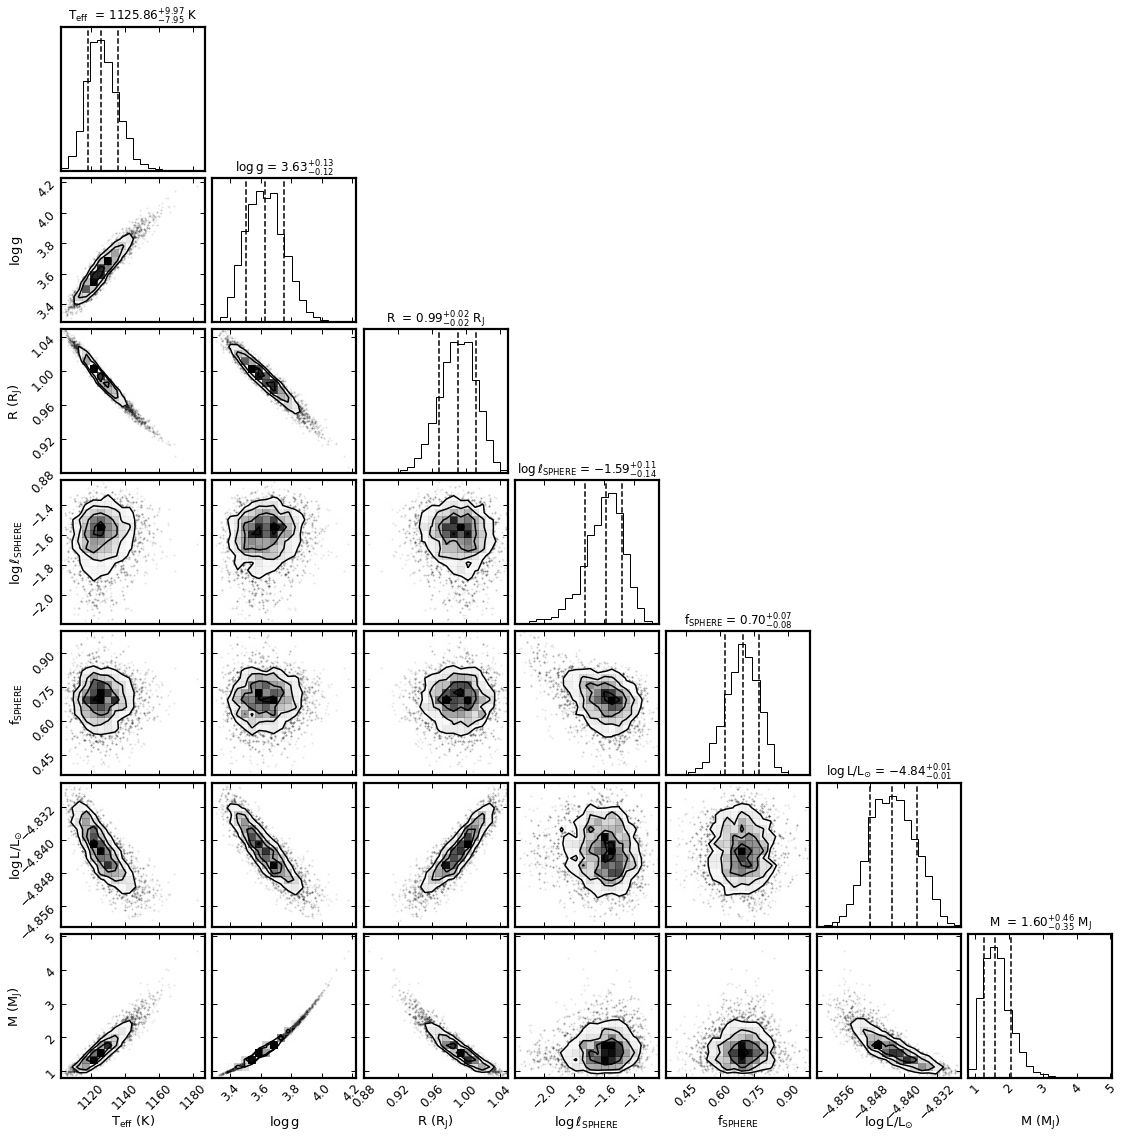

In [ ]:
species.plot_posterior(tag='hd13724b',
                       burnin=None,
                       title=None,
                       offset=(-0.25, -0.25),
                       title_fmt='.2f',
                       inc_luminosity=True,
                       inc_mass=True,
                       output='posterior.png')
from IPython.display import Image
Image('posterior.png')

We select 30 random samples from the posterior and use these parameters to interpolate the ATMO grid. To do so, we use the get_mcmc_spectra method of the Database and smooth the spectra to a resolution of R=30 to match the resolution of the SPHERE spectrum.

In [ ]:
samples = database.get_mcmc_spectra(tag='hd13724b',
                                    random=30,
                                    wavel_range=None,
                                    spec_res=30.)

Getting MCMC spectra: 100%|██████████| 30/30 [00:00<00:00, 133.45it/s]


We can have a look at the content of the first box by running the open_box() method.

In [ ]:
samples[0].open_box()

Opening ModelBox...
model = atmo
type = None
wavelength = [0.8        0.80039607 0.80079234 ... 2.79722955 2.79861443 2.8       ]
flux = [3.26192048e-18 3.29715952e-18 3.33356419e-18 ... 2.38783688e-17
 2.39050992e-17 2.39315507e-17]
parameters = {'teff': 1121.99102877261, 'logg': 3.5388781686732176, 'radius': 1.0049583530968587, 'distance': 43.47826086956522, 'luminosity': 1.4561106100105591e-05, 'mass': 1.3475595449532123}
quantity = flux


We obtain the median parameter values with the get_median_sample method and adopt these as best-fit parameters.

In [ ]:
best = database.get_median_sample(tag='hd13724b')

The best-fit model spectrum is now extracted from the ATMO grid by using the functionalities of the ReadModel class.

In [ ]:
read_model = species.ReadModel(model='atmo',wavel_range=None)

The grid is interpolated at the best-fit parameters with get_model. The spectrum is smoothed to a resolution of R=30 to match the resolution of SPHERE.

In [ ]:
modelbox = read_model.get_model(model_param=best,spec_res=30,smooth=True)

/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_len_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '
/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_amp_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '


We also extract all spectra and photometric fluxes with the get_object method.

In [ ]:
objectbox = database.get_object(object_name='HD 13724 B',
                                inc_phot=True,
                                inc_spec=True)

Getting object: HD 13724 B... [DONE]


We then run the ObjectBox through the update_spectra function with the best-fit parameters. This function applies the flux scaling.

In [ ]:
objectbox = species.update_spectra(objectbox=objectbox,model_param=best)

We then calculate the residuals of the best-fit models with get_residuals. This function will interpolate the grid at the specified parameters, calculate synthetic photometry for the filters that are provided, and smooth and resample the spectra to the resolution and wavelengths of the spectra that are provided by inc_spec.

In [ ]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='atmo',
                                  parameters=best,
                                  objectbox=objectbox,
                                  inc_phot=inc_phot,
                                  inc_spec=True)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - Paranal/SPHERE.IRDIS_D_H23_2: 2.95
   - Paranal/SPHERE.IRDIS_D_H23_3: -5.10
   - Paranal/SPHERE.IRDIS_D_J23_2: 1.65
   - Paranal/SPHERE.IRDIS_D_J23_3: -1.81
   - Paranal/SPHERE.IRDIS_D_K12_1: 5.25
   - Paranal/SPHERE.IRDIS_D_K12_2: 18.53
   - SPHERE: min: -4.04, max: 3.29


/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_len_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '
/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_amp_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '


We then compute synthetic photometry from the best-fit model spectrum with the multi_photometry function.

In [ ]:
synphot = species.multi_photometry(datatype='model',
                                   spectrum='atmo',
                                   filters=objectbox.filters,
                                   parameters=best)

Calculating synthetic photometry... [DONE]


/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_len_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '
/usr/local/lib/python3.7/dist-packages/species/read/read_model.py:601: UserWarning: The 'corr_amp_SPHERE' parameter is not required by 'atmo' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg'].
  warnings.warn(f'The \'{key}\' parameter is not required by \'{self.model}\' so '


And we can also have a look inside synphotbox:

In [ ]:
synphot.open_box()

Opening SynphotBox...
name = synphot
flux = {'Paranal/SPHERE.IRDIS_D_H23_2': 1.8602233428741296e-16, 'Paranal/SPHERE.IRDIS_D_H23_3': 9.96597978148279e-17, 'Paranal/SPHERE.IRDIS_D_J23_2': 1.522303060854262e-16, 'Paranal/SPHERE.IRDIS_D_J23_3': 4.2639878248648633e-16, 'Paranal/SPHERE.IRDIS_D_K12_1': 9.14347222722311e-17, 'Paranal/SPHERE.IRDIS_D_K12_2': 8.952256954459167e-18}


Now that we have gather all the Box objects with the results, we can pass them as list to the boxes parameter of the plot_spectrum function. The ResidualsBox is separately provided as argument of residuals. We also include a list of filter names for which the transmission profiles will be plotted. The arguments of residuals and filters can also be set to None to not include these data in the plot.

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
species.plot_spectrum(boxes=[modelbox,objectbox,synphot],
                      filters = objectbox.filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 3., 'color': 'orange'},
                                   {'Paranal/SPHERE.IRDIS_D_J23_2': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_J23_3': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_H23_2': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_H23_3': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_K12_1': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_K12_2': {'marker': 's', 'ms': 5., 'color': 'black', 'ls': 'none'},
                                    'SPHERE': {'marker': 'v', 'ms': 5., 'color': 'purple', 'ls': 'none'}},
                                   None],
                      xlim=(0.8, 2.8),
                      ylim=(-5e-17, 50e-17),
                      scale=('linear', 'linear'),
                      offset=(-0.06, -0.03),
                      legend=[{'loc': 'upper right', 'frameon': False, 'fontsize': 12.},
                              None],
                      output='spectrum.png')

Plotting spectrum: spectrum.png...

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Bitstream Vera Serif


 [DONE]


And let's have a look at the result!

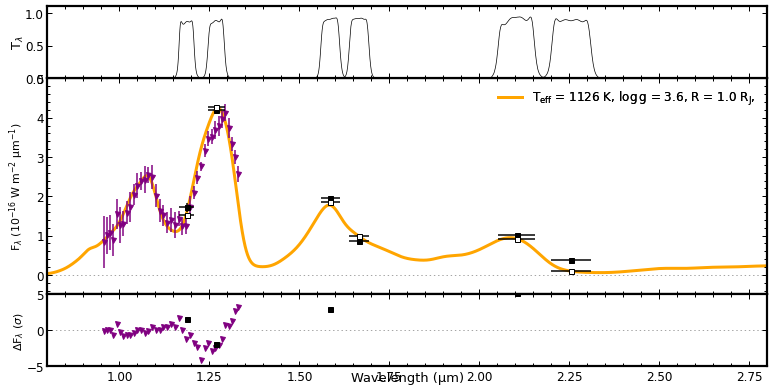

In [ ]:
Image('spectrum.png')

We can compare this to the published version of this spectrum (Rickman et al 2020):
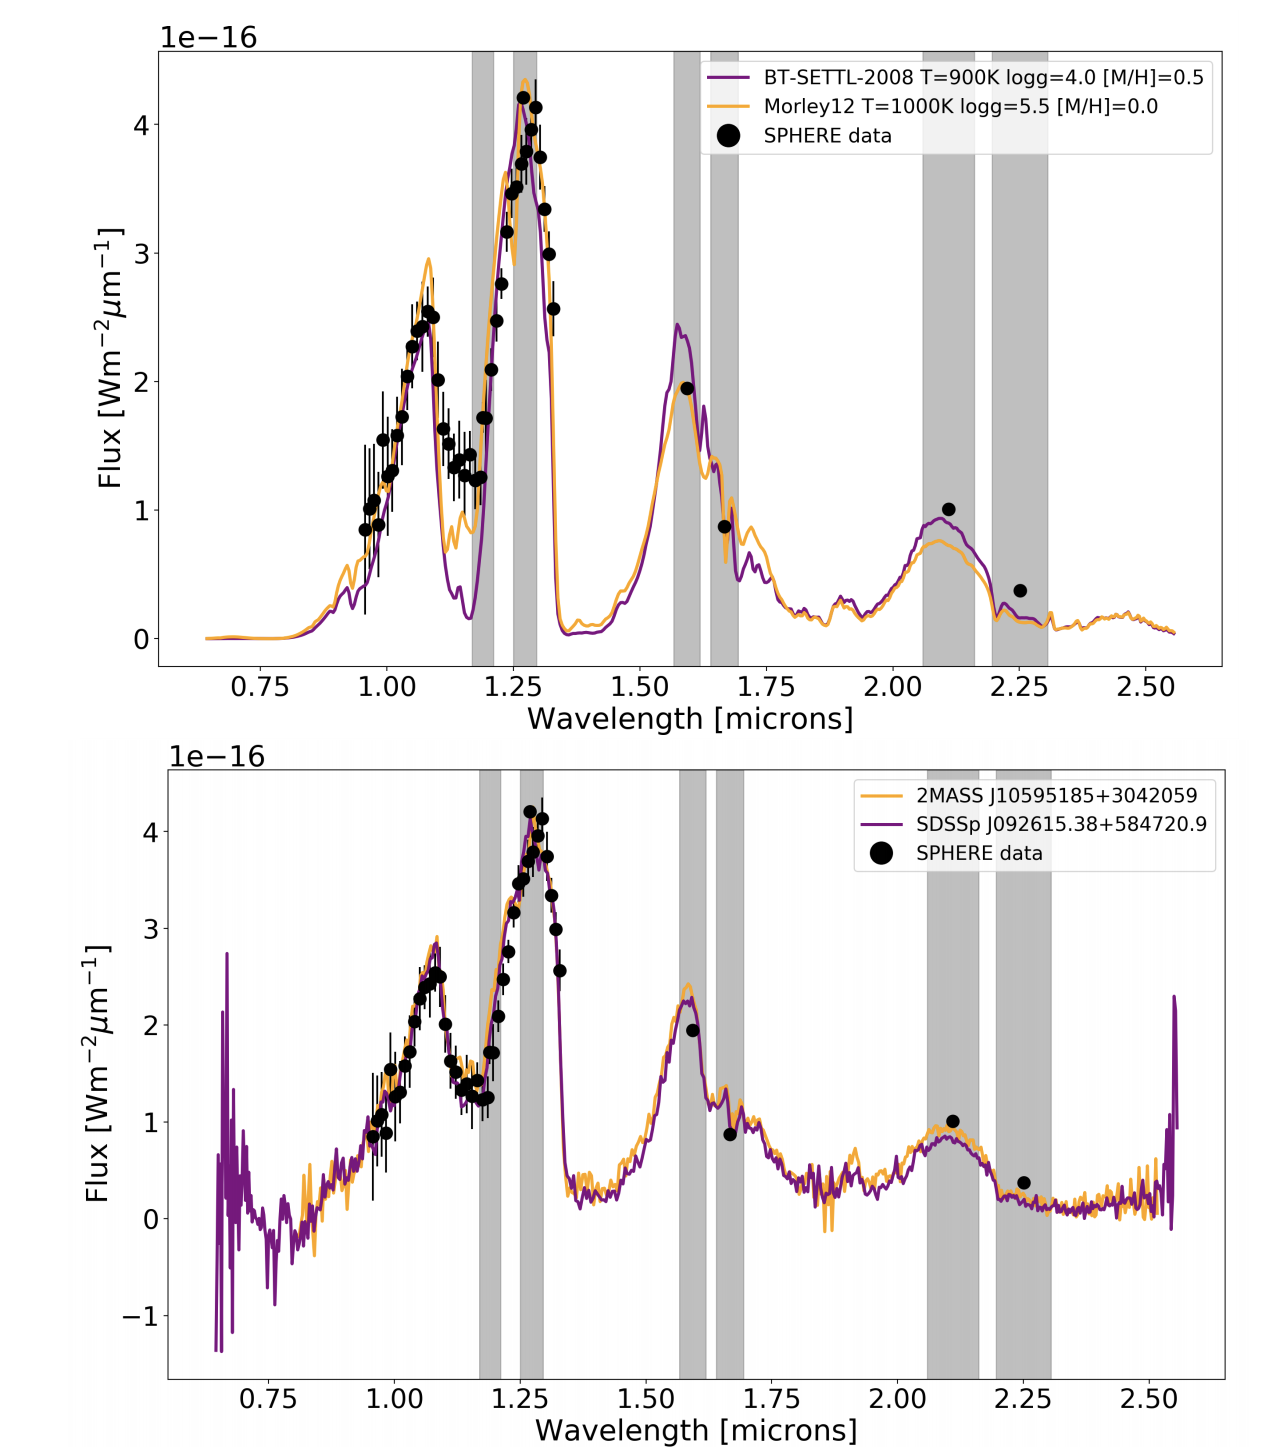